In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
pd.set_option('mode.chained_assignment',  None)
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거


In [2]:
train_data = pd.read_csv('train_merge_data.csv')
test_data = pd.read_csv('test_merge_data.csv')

C:\Users\82104\AppData\Local\Temp\ipykernel_13016\1944733010.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_merge_data.csv')


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 24 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   id            int64  
 2   date          object 
 3   store_nbr     int64  
 4   family        object 
 5   sales         float64
 6   onpromotion   int64  
 7   dcoilwtico    float64
 8   type_x        object 
 9   locale        object 
 10  locale_name   object 
 11  description   object 
 12  transferred   object 
 13  transactions  float64
 14  city          object 
 15  state         object 
 16  type_y        object 
 17  cluster       int64  
 18  Year          int64  
 19  Month         int64  
 20  Weekend       int64  
 21  Weekday       int64  
 22  trend         int64  
 23  NewYearsDay   bool   
dtypes: bool(1), float64(3), int64(10), object(10)
memory usage: 538.9+ MB


### feature
- date : 날짜
- store_nbr : store number
- family : 물건 종류
- onpromotion : 프로모션 행사 제품 수
- dcoilwtico : oil가격
- type_x : holiday type
  - ['Holiday', 'Empty', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge']
- locale : holiday가 적용되는 범위
  - ['National', 'Empty', 'Local', 'Regional']
- locale_name : holiday가 적용되는 지역명
  - ['Ecuador', 'Empty', 'Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo', 'Guaranda', 'Imbabura', 'Machala', 'Latacunga','El Carmen', 'Santo Domingo', 'Cayambe', 'Guayaquil', 'Esmeraldas','Ambato', 'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas','Santa Elena', 'Quito', 'Loja', 'Salinas']
- description : holiday설명
- trasnferred : 연휴 이동 여부
- transactions : 거래량 (na값은 선형회귀모형으로 대체)
- city : store의 city
- state store의 주
- type_y : store의 type
- cluster : 소매점의 개수
- year : 연도
- Month :월 
- Weekend : 주말 여부
- Weekday : 요일 (월:0 ~ 일:6)
- trend
- NewYearsDay : 새해 여부

### target
- sales

In [4]:
train_data.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,type_x,locale,...,city,state,type_y,cluster,Year,Month,Weekend,Weekday,trend,NewYearsDay
0,0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
1,1,1,2013-01-01,1,BABY CARE,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
2,2,2,2013-01-01,1,BEAUTY,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
3,3,3,2013-01-01,1,BEVERAGES,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True
4,4,4,2013-01-01,1,BOOKS,0.0,0,93.14,Holiday,National,...,Quito,Pichincha,D,13,2013,1,0,1,0,True


#### 1. city, state 제거
- store_nbr에 지역 정보가 담겨있다고 해석 가능.

In [5]:
# city, state 제거
train_data.drop(columns = ['city','state'], inplace = True)
test_data.drop(columns = ['city', 'state'], inplace = True)

#### 2. description 정보 빼내기
- Terremoto가 포함된 행 => Earthquake
- futbol이 포함된 행 => Football
- Cyber Monday : 사이버 먼데이는 11월 넷째주 목요일인 미국의 추수감사절 다음주 첫 번째 월요일을 뜻하는 마케팅 용어이다. 마케팅 회사들이 연휴가 끝난 후 일상 생활에서 복귀한 소비자들에게 온라인으로 물건을 구입하도록 독려한데서 나왔다.
- Black Friday
- Dia de la Madre : 어머니날 (5월 8일 일요일)

In [6]:
train_data.loc[train_data['description'].str.contains('Terremoto', na=False),'description'] = 'Earthquake'
train_data.loc[train_data['description'].str.contains('futbol', na=False), 'description'] = 'Football'
# test_data에는 해당정보 없음. 

In [7]:
train_descriptions = pd.get_dummies(train_data['description'])[['Earthquake', 'Cyber Monday','Football', 'Black Friday', 'Dia de la Madre']]
train_data = train_data.merge(train_descriptions, how = 'left', left_index = True, right_index = True)
test_data['Earthquake'] = 0
test_data['Cyber Monday'] = 0
test_data['Football'] = 0
test_data['Black Friday'] = 0
test_data['Dia de la Madre'] = 0

In [8]:
print(train_data.shape)
print(test_data.shape)

(3054348, 27)
(28512, 26)


#### 3. type_x
- 그렇게 큰 의미가 있는 정보가 없는 듯 하여 위의 나경님 코드에 Dia de la Madre(어머니날)만 추가하고, 저번주와 같은 방식으로 holiday(휴일) 정보만 빼오기로 했다.

In [9]:
train_data.type_x.unique()

array(['Holiday', 'Empty', 'Work Day', 'Additional', 'Event', 'Transfer',
       'Bridge'], dtype=object)

In [10]:
train_data[train_data.type_x == 'Event']['description'].unique()

array(['Dia de la Madre', 'Football', 'Black Friday', 'Cyber Monday',
       'Earthquake'], dtype=object)

In [11]:
train_data[train_data.type_x == 'Bridge']['description'].unique()

array(['Puente Navidad', 'Puente Primer dia del ano',
       'Puente Dia de Difuntos'], dtype=object)

In [12]:
train_data[train_data.type_x == 'Holiday']['description'].unique()

array(['Primer dia del ano', 'Carnaval', 'Fundacion de Manta',
       'Provincializacion de Cotopaxi', 'Fundacion de Cuenca',
       'Cantonizacion de Libertad', 'Cantonizacion de Riobamba',
       'Viernes Santo', 'Dia del Trabajo', 'Cantonizacion del Puyo',
       'Batalla de Pichincha', 'Cantonizacion de Guaranda',
       'Provincializacion de Imbabura', 'Fundacion de Machala',
       'Cantonizacion de Latacunga', 'Cantonizacion de El Carmen',
       'Fundacion de Santo Domingo', 'Cantonizacion de Cayambe',
       'Fundacion de Guayaquil', 'Fundacion de Esmeraldas',
       'Primer Grito de Independencia', 'Fundacion de Riobamba',
       'Fundacion de Ambato', 'Fundacion de Ibarra',
       'Cantonizacion de Quevedo', 'Independencia de Guayaquil',
       'Dia de Difuntos', 'Independencia de Cuenca',
       'Provincializacion de Santo Domingo',
       'Provincializacion Santa Elena', 'Independencia de Guaranda',
       'Independencia de Latacunga', 'Independencia de Ambato',
       'Fu

In [13]:
train_data[train_data.type_x == 'Additional']['description'].unique()

array(['Dia de la Madre-1', 'Fundacion de Guayaquil-1',
       'Fundacion de Quito-1', 'Navidad-4', 'Navidad-3', 'Navidad-2',
       'Navidad-1', 'Navidad+1', 'Primer dia del ano-1',
       'Fundacion de Guayaquil'], dtype=object)

In [14]:
train_data[train_data.type_x == 'Transfer']['description'].unique()

array(['Traslado Independencia de Guayaquil',
       'Traslado Batalla de Pichincha', 'Traslado Fundacion de Guayaquil',
       'Traslado Primer Grito de Independencia',
       'Traslado Primer dia del ano', 'Fundacion de Cuenca'], dtype=object)

In [15]:
train_data[train_data.type_x == 'Work Day']['description'].unique()

array(['Recupero puente Navidad', 'Recupero puente primer dia del ano',
       'Recupero Puente Navidad', 'Recupero Puente Primer dia del ano',
       'Recupero Puente Dia de Difuntos'], dtype=object)

#### 4. holiday 변수 생성(휴일) - 지난주와 동일
- 우선 국가적인 행사는 휴일에 영향을 미치기 때문에 holiday 정보를 바로 모델에 사용하기 보다는 holiday에서 연휴가 된 날을 찾고자 했다. 따라서 National 정보만 남기고, 다른 날로 대체된 날도 제거한 뒤, type_x가 'holiday', 'additional', 'bridge'인 날만 남겼다. 이를 holiday라는 열로 만들고, 기존의 weekend(주말) column과 or 연산을 통해 no_work_day column을 만들었다. 그 뒤 holiday와 관련된 columns을 모두 drop 시켰다. test_data의 경우 위의 과정을 거쳤을 때 모든 열이 Empty가 되었기 때문에 weekend를 그대로 no_work_day로 이용했다.

In [16]:
# National인 holiday 정보만 남긴다.
mask = (train_data.locale != 'National')
train_data.type_x[mask] = 'Empty'
train_data.locale[mask] = 'Empty'
train_data.locale_name[mask] = 'Empty'
train_data.transferred[mask] = 'Empty'

mask = (test_data.locale != 'National')
test_data.type_x[mask] = 'Empty'
test_data.locale[mask] = 'Empty'
test_data.locale_name[mask] = 'Empty'
test_data.transferred[mask] = 'Empty'

In [17]:
# 다른날로 대체된 날을 Empty로 변경
mask = (train_data.transferred == 'True')
train_data.type_x[mask] = 'Empty'
train_data.locale[mask] = 'Empty'
train_data.locale_name[mask] = 'Empty'
train_data.transferred[mask] = 'Empty'

mask = (test_data.transferred == 'True')
test_data.type_x[mask] = 'Empty'
test_data.locale[mask] = 'Empty'
test_data.locale_name[mask] = 'Empty'
test_data.transferred[mask] = 'Empty'

In [18]:
# 쉬는 날: holiday, additional, bridge
mask = ((train_data.type_x == 'Holiday') | (train_data.type_x == 'Additional') | (train_data.type_x == 'Bridge'))
# 주말이거나 holiday인 날을 no_work_day로 지정
train_data['no_work_day'] = train_data['Weekend'] | mask
# 테스트 데이터는 위의 정보가 없기 때문에 그냥 Weekend를 no_work_day로 변경
test_data['no_work_day'] = test_data['Weekend']

In [19]:
print(train_data.shape)
print(test_data.shape)

(3054348, 28)
(28512, 27)


In [20]:
final_train_data = train_data.drop(columns = ['Unnamed: 0','id','type_x', 'locale', 'locale_name', 'transferred','Weekend','description'])
final_test_data = test_data.drop(columns = ['Unnamed: 0', 'id','type_x', 'locale', 'locale_name', 'transferred', 'description','Weekend'])

In [21]:
print(final_train_data.shape)
print(final_test_data.shape)

(3054348, 20)
(28512, 19)


In [22]:
final_train_data.columns

Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'dcoilwtico',
       'transactions', 'type_y', 'cluster', 'Year', 'Month', 'Weekday',
       'trend', 'NewYearsDay', 'Earthquake', 'Cyber Monday', 'Football',
       'Black Friday', 'Dia de la Madre', 'no_work_day'],
      dtype='object')

In [23]:
final_test_data.columns

Index(['date', 'store_nbr', 'family', 'onpromotion', 'dcoilwtico',
       'transactions', 'type_y', 'cluster', 'Year', 'Month', 'Weekday',
       'trend', 'NewYearsDay', 'Earthquake', 'Cyber Monday', 'Football',
       'Black Friday', 'Dia de la Madre', 'no_work_day'],
      dtype='object')

**최종 전처리 데이터 추출 위치**

In [24]:
#final_train_data.to_csv('final_train_data.csv', index = False)

In [25]:
#final_test_data.to_csv('final_test_data.csv', index = False)

In [26]:
# 확인용
pd.read_csv('final_train_data.csv')

,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,type_y,cluster,Year,Month,Weekday,trend,NewYearsDay,Earthquake,Cyber Monday,Football,Black Friday,Dia de la Madre,no_work_day
0,2013-01-01,1,AUTOMOTIVE,0.000,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
1,2013-01-01,1,BABY CARE,0.000,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
2,2013-01-01,1,BEAUTY,0.000,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
3,2013-01-01,1,BEVERAGES,0.000,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
4,2013-01-01,1,BOOKS,0.000,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,2017-08-15,9,POULTRY,438.133,0,47.57,2155.000000,B,6,2017,8,1,1687,False,0,0,0,0,0,False
3054344,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,2155.000000,B,6,2017,8,1,1687,False,0,0,0,0,0,False
3054345,2017-08-15,9,PRODUCE,2419.729,148,47.57,2155.000000,B,6,2017,8,1,1687,False,0,0,0,0,0,False
3054346,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,2155.000000,B,6,2017,8,1,1687,False,0,0,0,0,0,False


In [27]:
# 확인용
pd.read_csv('final_test_data.csv')

,date,store_nbr,family,onpromotion,dcoilwtico,transactions,type_y,cluster,Year,Month,Weekday,trend,NewYearsDay,Earthquake,Cyber Monday,Football,Black Friday,Dia de la Madre,no_work_day
0,2017-08-16,1,AUTOMOTIVE,0,46.80,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
1,2017-08-16,1,BABY CARE,0,46.80,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
2,2017-08-16,1,BEAUTY,2,46.80,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
3,2017-08-16,1,BEVERAGES,20,46.80,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
4,2017-08-16,1,BOOKS,0,46.80,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28507,2017-08-31,9,POULTRY,1,47.26,1986.976875,B,6,2017,8,3,1703,False,0,0,0,0,0,0
28508,2017-08-31,9,PREPARED FOODS,0,47.26,1986.976875,B,6,2017,8,3,1703,False,0,0,0,0,0,0
28509,2017-08-31,9,PRODUCE,1,47.26,1986.976875,B,6,2017,8,3,1703,False,0,0,0,0,0,0
28510,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9,47.26,1986.976875,B,6,2017,8,3,1703,False,0,0,0,0,0,0


### modeling

In [24]:
sub_train_data = final_train_data[train_data.date <= '2016-07-31']
valid_data = final_train_data[train_data.date >= '2016-08-01']

In [25]:
print(final_train_data.shape)
print(sub_train_data.shape)
print(valid_data.shape)
print(final_test_data.shape)

(3054348, 20)
(2368278, 20)
(686070, 20)
(28512, 19)


In [26]:
# 검증 과정에서 사용할 데이터
sub_train_data.drop(columns = ['date'], inplace = True)
valid_data.drop(columns = ['date'], inplace = True)

# 최종 모델 훈련에서 사용할 데이터
final_train_data.drop(columns = ['date'], inplace = True)
final_test_data.drop(columns = ['date'], inplace = True)

**sub_train, valid**

In [119]:
X_sub_train_data = sub_train_data.drop(columns = ['sales'])
y_sub_train_data = sub_train_data['sales']

X_valid_data = valid_data.drop(columns = ['sales'])
y_valid_data = valid_data['sales']

- 산점도 그리기 : https://rfriend.tistory.com/416

array([[<AxesSubplot:xlabel='onpromotion', ylabel='onpromotion'>,
        <AxesSubplot:xlabel='dcoilwtico', ylabel='onpromotion'>,
        <AxesSubplot:xlabel='transactions', ylabel='onpromotion'>],
       [<AxesSubplot:xlabel='onpromotion', ylabel='dcoilwtico'>,
        <AxesSubplot:xlabel='dcoilwtico', ylabel='dcoilwtico'>,
        <AxesSubplot:xlabel='transactions', ylabel='dcoilwtico'>],
       [<AxesSubplot:xlabel='onpromotion', ylabel='transactions'>,
        <AxesSubplot:xlabel='dcoilwtico', ylabel='transactions'>,
        <AxesSubplot:xlabel='transactions', ylabel='transactions'>]],
      dtype=object)

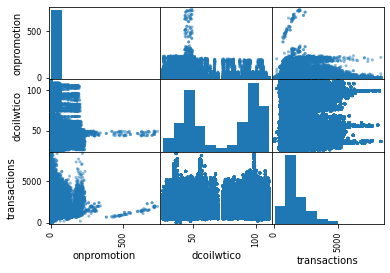

In [106]:
pd.plotting.scatter_matrix(X_sub_train_data[['onpromotion', 'dcoilwtico', 'transactions']])

array([[<AxesSubplot:title={'center':'store_nbr'}>,
        <AxesSubplot:title={'center':'onpromotion'}>,
        <AxesSubplot:title={'center':'dcoilwtico'}>,
        <AxesSubplot:title={'center':'transactions'}>],
       [<AxesSubplot:title={'center':'cluster'}>,
        <AxesSubplot:title={'center':'Year'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Weekday'}>],
       [<AxesSubplot:title={'center':'trend'}>,
        <AxesSubplot:title={'center':'Earthquake'}>,
        <AxesSubplot:title={'center':'Cyber Monday'}>,
        <AxesSubplot:title={'center':'Football'}>],
       [<AxesSubplot:title={'center':'Black Friday'}>,
        <AxesSubplot:title={'center':'Dia de la Madre'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

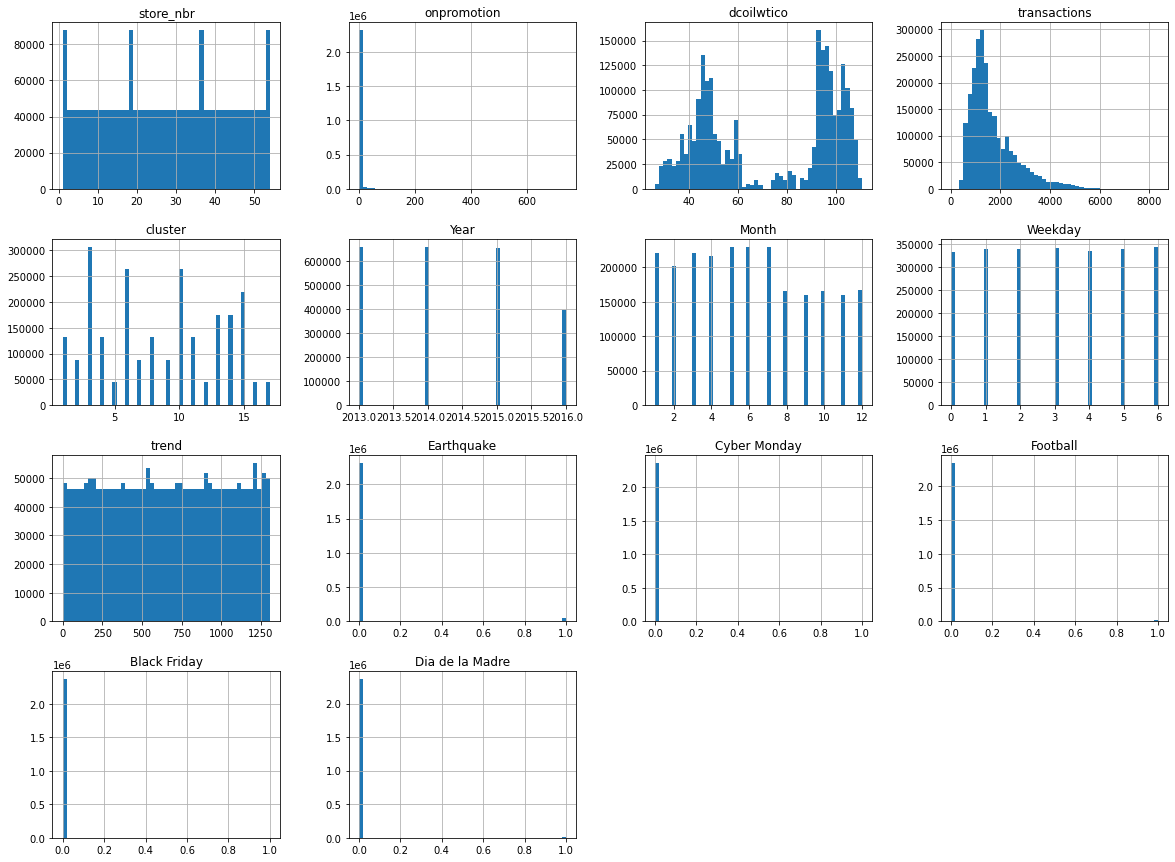

In [108]:
X_sub_train_data.hist(bins=50, figsize=(20, 15))

In [134]:
X_sub_train_data.columns

Index(['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'transactions',
       'type_y', 'cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay',
       'Earthquake', 'Cyber Monday', 'Football', 'Black Friday',
       'Dia de la Madre', 'no_work_day'],
      dtype='object')

In [120]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

preproc = ColumnTransformer(
    [('standard', StandardScaler(), ['transactions']),
     ('minmax', MinMaxScaler(), ['onpromotion', 'dcoilwtico']),
     ('cat', OneHotEncoder(sparse = False, drop = 'first'), ['store_nbr', 'family', 'type_y'])],
     remainder = 'passthrough')

preproc.fit(X_sub_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['transactions','onpromotion', 'dcoilwtico'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','Earthquake', 'Cyber Monday', 'Football', 'Black Friday','Dia de la Madre', 'no_work_day']])

X_sub_train_data_trans = pd.DataFrame(preproc.transform(X_sub_train_data), columns = labels)
X_valid_data_trans = pd.DataFrame(preproc.transform(X_valid_data), columns = labels)

##### LinearRegression

In [136]:
# modeling
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_sub_train_data_trans, y_sub_train_data)

LinearRegression()

In [137]:
# predict
train_pred = model.predict(X_sub_train_data_trans)
valid_pred = model.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [140]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  2.4489112119890386
검증데이터 rmsle:  2.3055143871527894


##### RandomForest

**1000000개만 사용**

In [141]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_sub_train_data_trans[-1000000:], y_sub_train_data[-1000000:])

RandomForestRegressor(min_samples_split=10)

In [142]:
# predict
train_pred = rfmodel.predict(X_sub_train_data_trans)
valid_pred = rfmodel.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [143]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  1.1087066993529981
검증데이터 rmsle:  0.729052152509706


**전체 sub_train data 사용**

In [121]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_sub_train_data_trans, y_sub_train_data)

RandomForestRegressor(min_samples_split=10)

In [122]:
# predict
train_pred = rfmodel.predict(X_sub_train_data_trans)
valid_pred = rfmodel.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [123]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  0.31105239914444327
검증데이터 rmsle:  0.712528585812691


**full_train, test**
- family 안 묶은 상태로 전체 데이터 훈련

In [27]:
X_train_data = final_train_data.drop(columns = ['sales'])
y_train_data = final_train_data['sales']

In [28]:
X_train_data.columns

Index(['store_nbr', 'family', 'onpromotion', 'dcoilwtico', 'transactions',
       'type_y', 'cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay',
       'Earthquake', 'Cyber Monday', 'Football', 'Black Friday',
       'Dia de la Madre', 'no_work_day'],
      dtype='object')

In [29]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

preproc = ColumnTransformer(
    [('standard', StandardScaler(), ['transactions']),
     ('minmax', MinMaxScaler(), ['onpromotion', 'dcoilwtico']),
     ('cat', OneHotEncoder(sparse = False, drop = 'first'), ['store_nbr', 'family', 'type_y'])],
     remainder = 'passthrough')

preproc.fit(X_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['transactions','onpromotion', 'dcoilwtico'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','Earthquake', 'Cyber Monday', 'Football', 'Black Friday','Dia de la Madre', 'no_work_day']])

X_train_data_trans = pd.DataFrame(preproc.transform(X_train_data), columns = labels)
X_test_data_trans = pd.DataFrame(preproc.transform(final_test_data), columns = labels)

In [30]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_train_data_trans, y_train_data)

RandomForestRegressor(min_samples_split=10)

In [31]:
train_pred = rfmodel.predict(X_train_data_trans)
test_pred = rfmodel.predict(X_test_data_trans)
train_pred[train_pred < 0] = 0
test_pred[test_pred < 0] = 0

In [32]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_train_data, train_pred)))

훈련데이터 rmsle:  0.3137456349712458


In [33]:
submission = pd.read_csv('sample_submission.csv')

In [34]:
submission['sales'] = test_pred

In [35]:
submission.to_csv('submission0212.csv', index = False)

#### 5. family 그룹화(X)

In [76]:
final_train_data['family'].replace(['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'], 'Tools', inplace = True)
final_train_data['family'].replace(['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'], 'LifeStyle', inplace = True)
final_train_data['family'].replace(['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES'], 'Home', inplace=True)
final_train_data['family'].replace([ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER'], 'Food', inplace=True)
final_train_data['family'].replace(['DELI', 'EGGS'], 'Daily', inplace=True)

final_test_data['family'].replace(['AUTOMOTIVE', 'HARDWARE', 'LAWN AND GARDEN', 'PLAYERS AND ELECTRONICS'], 'Tools', inplace = True)
final_test_data['family'].replace(['BEAUTY', 'LINGERIE', 'LADIESWEAR','PERSONAL CARE','CELEBRATION','MAGAZINES','BOOKS', 'BABY CARE'], 'LifeStyle', inplace = True)
final_test_data['family'].replace(['HOME APPLIANCES','HOME AND KITCHEN I', 'HOME AND KITCHEN II','HOME CARE','SCHOOL AND OFFICE SUPPLIES'], 'Home', inplace=True)
final_test_data['family'].replace([ 'GROCERY II', 'PET SUPPLIES','SEAFOOD','LIQUOR,WINE,BEER'], 'Food', inplace=True)
final_test_data['family'].replace(['DELI', 'EGGS'], 'Daily', inplace=True)

print(final_train_data['family'].unique())
print(final_test_data['family'].unique())

['Tools' 'LifeStyle' 'BEVERAGES' 'BREAD/BAKERY' 'CLEANING' 'DAIRY' 'Daily'
 'FROZEN FOODS' 'GROCERY I' 'Food' 'Home' 'MEATS' 'POULTRY'
 'PREPARED FOODS' 'PRODUCE']
['Tools' 'LifeStyle' 'BEVERAGES' 'BREAD/BAKERY' 'CLEANING' 'DAIRY' 'Daily'
 'FROZEN FOODS' 'GROCERY I' 'Food' 'Home' 'MEATS' 'POULTRY'
 'PREPARED FOODS' 'PRODUCE']


### modeling

In [77]:
sub_train_data = final_train_data[train_data.date <= '2016-07-31']
valid_data = final_train_data[train_data.date >= '2016-08-01']

In [78]:
print(final_train_data.shape)
print(sub_train_data.shape)
print(valid_data.shape)
print(final_test_data.shape)

(3054348, 20)
(2368278, 20)
(686070, 20)
(28512, 19)


In [79]:
sub_train_data['family'].unique()

array(['Tools', 'LifeStyle', 'BEVERAGES', 'BREAD/BAKERY', 'CLEANING',
       'DAIRY', 'Daily', 'FROZEN FOODS', 'GROCERY I', 'Food', 'Home',
       'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE'], dtype=object)

In [80]:
final_test_data['family'].unique()

array(['Tools', 'LifeStyle', 'BEVERAGES', 'BREAD/BAKERY', 'CLEANING',
       'DAIRY', 'Daily', 'FROZEN FOODS', 'GROCERY I', 'Food', 'Home',
       'MEATS', 'POULTRY', 'PREPARED FOODS', 'PRODUCE'], dtype=object)

In [81]:
# 검증 과정에서 사용할 데이터
sub_train_data.drop(columns = ['date'], inplace = True)
valid_data.drop(columns = ['date'], inplace = True)
# 최종 모델 훈련에서 사용할 데이터
final_train_data.drop(columns = ['date'], inplace = True)
final_test_data.drop(columns = ['date'], inplace = True)

**sub_train, valid**

In [82]:
X_sub_train_data = sub_train_data.drop(columns = ['sales'])
y_sub_train_data = sub_train_data['sales']

X_valid_data = valid_data.drop(columns = ['sales'])
y_valid_data = valid_data['sales']

In [83]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

preproc = ColumnTransformer(
    [('standard', StandardScaler(), ['transactions']),
     ('minmax', MinMaxScaler(), ['onpromotion', 'dcoilwtico']),
     ('cat', OneHotEncoder(sparse = False, drop = 'first'), ['store_nbr', 'family', 'type_y'])],
     remainder = 'passthrough')

preproc.fit(X_sub_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['transactions','onpromotion', 'dcoilwtico'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','Earthquake', 'Cyber Monday', 'Football', 'Black Friday','Dia de la Madre', 'no_work_day']])

X_sub_train_data_trans = pd.DataFrame(preproc.transform(X_sub_train_data), columns = labels)
X_valid_data_trans = pd.DataFrame(preproc.transform(X_valid_data), columns = labels)

**Linear Regression**

In [85]:
# modeling
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_sub_train_data_trans, y_sub_train_data)

LinearRegression()

In [86]:
# predict
train_pred = model.predict(X_sub_train_data_trans)
valid_pred = model.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [87]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  2.5815920597190765
검증데이터 rmsle:  2.417274741334595


**RandomForest**

**1000000개만 사용**

In [88]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_sub_train_data_trans[-1000000:], y_sub_train_data[-1000000:])

RandomForestRegressor(min_samples_split=10)

In [89]:
# predict
train_pred = rfmodel.predict(X_sub_train_data_trans)
valid_pred = rfmodel.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [90]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  1.8723167115472557
검증데이터 rmsle:  1.3354254075548169


**전체 sub_train_data 사용**

In [91]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_sub_train_data_trans, y_sub_train_data)

RandomForestRegressor(min_samples_split=10)

In [92]:
# predict
train_pred = rfmodel2.predict(X_sub_train_data_trans)
valid_pred = rfmodel2.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [93]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  1.4712482650871497
검증데이터 rmsle:  1.3224204508004491


#### 6. 푸리에 변환(Fourier transform)


In [183]:
final_train_data.head()

,date,store_nbr,family,sales,onpromotion,dcoilwtico,transactions,type_y,cluster,Year,Month,Weekday,trend,NewYearsDay,Earthquake,Cyber Monday,Football,Black Friday,Dia de la Madre,no_work_day
0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
1,2013-01-01,1,BABY CARE,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
2,2013-01-01,1,BEAUTY,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
3,2013-01-01,1,BEVERAGES,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True
4,2013-01-01,1,BOOKS,0.0,0,93.14,1420.876311,D,13,2013,1,1,0,True,0,0,0,0,0,True


In [184]:
final_test_data.head()

,date,store_nbr,family,onpromotion,dcoilwtico,transactions,type_y,cluster,Year,Month,Weekday,trend,NewYearsDay,Earthquake,Cyber Monday,Football,Black Friday,Dia de la Madre,no_work_day
0,2017-08-16,1,AUTOMOTIVE,0,46.8,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
1,2017-08-16,1,BABY CARE,0,46.8,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
2,2017-08-16,1,BEAUTY,2,46.8,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
3,2017-08-16,1,BEVERAGES,20,46.8,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0
4,2017-08-16,1,BOOKS,0,46.8,1448.259579,D,13,2017,8,2,1688,False,0,0,0,0,0,0


In [185]:
from datetime import datetime, timedelta

def date_range(start, end):
    start = datetime.strptime(start, "%Y-%m-%d")
    end = datetime.strptime(end, "%Y-%m-%d")
    dates = [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range((end-start).days+1)]
    return dates

dates = date_range("2013-01-01", "2017-08-16")
#print(dates)

In [186]:
# CalendarFourier
from statsmodels.tsa.deterministic import CalendarFourier

index = pd.DatetimeIndex(pd.to_datetime(dates))

cal_fourier_gen = CalendarFourier(freq = "A", order = 5)
fourier_lst = cal_fourier_gen.in_sample(index).head()
fourier_lst = fourier_lst.reset_index()

In [187]:
fourier_lst.columns = ['date']+['fourier_'+ str(i) for i in range(1,11)] 

In [188]:
fourier_lst.columns

Index(['date', 'fourier_1', 'fourier_2', 'fourier_3', 'fourier_4', 'fourier_5',
       'fourier_6', 'fourier_7', 'fourier_8', 'fourier_9', 'fourier_10'],
      dtype='object')

In [189]:
fourier_lst.head()

,date,fourier_1,fourier_2,fourier_3,fourier_4,fourier_5,fourier_6,fourier_7,fourier_8,fourier_9,fourier_10
0,2013-01-01,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,2013-01-02,0.017213,0.999852,0.034422,0.999407,0.051620,0.998667,0.068802,0.997630,0.085965,0.996298
2,2013-01-03,0.034422,0.999407,0.068802,0.997630,0.103102,0.994671,0.137279,0.990532,0.171293,0.985220
3,2013-01-04,0.051620,0.998667,0.103102,0.994671,0.154309,0.988023,0.205104,0.978740,0.255353,0.966848
4,2013-01-05,0.068802,0.997630,0.137279,0.990532,0.205104,0.978740,0.271958,0.962309,0.337523,0.941317


In [190]:
fourier_lst = fourier_lst.astype({'date':'string'})

In [191]:
final_train_data = pd.merge(final_train_data, fourier_lst, left_on = 'date', right_on = 'date', how = 'left')
final_test_data = pd.merge(final_test_data, fourier_lst, left_on = 'date', right_on = 'date', how = 'left')


In [192]:
final_train_data['transactions'][final_train_data['transactions'] < 0] = 0
final_test_data['transactions'][final_test_data['transactions'] < 0] = 0

**modeling**

In [193]:
sub_train_data = final_train_data[train_data.date <= '2016-07-31']
valid_data = final_train_data[train_data.date >= '2016-08-01']

In [194]:
print(final_train_data.shape)
print(sub_train_data.shape)
print(valid_data.shape)
print(final_test_data.shape)

(3054348, 30)
(2368278, 30)
(686070, 30)
(28512, 29)


In [195]:
# 검증 과정에서 사용할 데이터
sub_train_data.drop(columns = ['date'], inplace = True)
valid_data.drop(columns = ['date'], inplace = True)
# 최종 모델 훈련에서 사용할 데이터
final_train_data.drop(columns = ['date'], inplace = True)
final_test_data.drop(columns = ['date'], inplace = True)

In [196]:
X_sub_train_data = sub_train_data.drop(columns = ['sales'])
y_sub_train_data = sub_train_data['sales']

X_valid_data = valid_data.drop(columns = ['sales'])
y_valid_data = valid_data['sales']

In [197]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

preproc = ColumnTransformer(
    [('standard', StandardScaler(), ['transactions']),
     ('minmax', MinMaxScaler(), ['onpromotion', 'dcoilwtico']),
     ('cat', OneHotEncoder(sparse = False, drop = 'first'), ['store_nbr', 'family', 'type_y'])],
     remainder = 'passthrough')

preproc.fit(X_sub_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['transactions','onpromotion', 'dcoilwtico'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','Earthquake', 'Cyber Monday', 'Football', 'Black Friday','Dia de la Madre', 'no_work_day'],['fourier_'+ str(i) for i in range(1,11)]])

X_sub_train_data_trans = pd.DataFrame(preproc.transform(X_sub_train_data), columns = labels)
X_valid_data_trans = pd.DataFrame(preproc.transform(X_valid_data), columns = labels)

ValueError: Shape of passed values is (2368278, 114), indices imply (2368278, 124)

**Linear Regression**

In [ ]:
X_sub_train_data_trans.head()

In [ ]:
X_valid_data_trans.head()

In [ ]:
# modeling
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_sub_train_data_trans, y_sub_train_data)

In [ ]:
# predict
train_pred = model.predict(X_sub_train_data_trans)
valid_pred = model.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [ ]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

#### 7. transaction 제거

In [60]:
final_train_data.drop(columns = ['transactions'], inplace = True)
final_test_data.drop(columns = ['transactions'], inplace = True)

In [61]:
sub_train_data = final_train_data[train_data.date <= '2016-07-31']
valid_data = final_train_data[train_data.date >= '2016-08-01']

In [62]:
print(final_train_data.shape)
print(sub_train_data.shape)
print(valid_data.shape)
print(final_test_data.shape)

(3054348, 19)
(2368278, 19)
(686070, 19)
(28512, 18)


In [63]:
# 검증 과정에서 사용할 데이터
sub_train_data.drop(columns = ['date'], inplace = True)
valid_data.drop(columns = ['date'], inplace = True)
# 최종 모델 훈련에서 사용할 데이터
final_train_data.drop(columns = ['date'], inplace = True)
final_test_data.drop(columns = ['date'], inplace = True)

In [64]:
X_sub_train_data = sub_train_data.drop(columns = ['sales'])
y_sub_train_data = sub_train_data['sales']

X_valid_data = valid_data.drop(columns = ['sales'])
y_valid_data = valid_data['sales']

In [66]:
# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

preproc = ColumnTransformer(
    [('minmax', MinMaxScaler(), ['onpromotion', 'dcoilwtico']),
     ('cat', OneHotEncoder(sparse = False, drop = 'first'), ['store_nbr', 'family', 'type_y'])],
     remainder = 'passthrough')

preproc.fit(X_sub_train_data)
cat_features_names = preproc.named_transformers_['cat'].get_feature_names()
labels = np.concatenate([['onpromotion', 'dcoilwtico'], cat_features_names, ['cluster', 'Year', 'Month', 'Weekday', 'trend', 'NewYearsDay','Earthquake', 'Cyber Monday', 'Football', 'Black Friday','Dia de la Madre', 'no_work_day']])

X_sub_train_data_trans = pd.DataFrame(preproc.transform(X_sub_train_data), columns = labels)
X_valid_data_trans = pd.DataFrame(preproc.transform(X_valid_data), columns = labels)

**Linear Regression**

In [68]:
# modeling
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_sub_train_data_trans, y_sub_train_data)

LinearRegression()

In [69]:
# predict
train_pred = model.predict(X_sub_train_data_trans)
valid_pred = model.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [70]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  2.4699533815769676
검증데이터 rmsle:  2.3188424251925572


**RandomForest**

In [71]:
from sklearn.ensemble import RandomForestRegressor

rfmodel = RandomForestRegressor(min_samples_split = 10)
rfmodel.fit(X_sub_train_data_trans, y_sub_train_data)

RandomForestRegressor(min_samples_split=10)

In [72]:
# predict
train_pred = rfmodel.predict(X_sub_train_data_trans)
valid_pred = rfmodel.predict(X_valid_data_trans)

train_pred[train_pred < 0] = 0
valid_pred[valid_pred < 0] = 0

In [73]:
from sklearn.metrics import mean_squared_log_error
print('훈련데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_sub_train_data, train_pred)))
print('검증데이터 rmsle: ', np.sqrt(mean_squared_log_error(y_valid_data, valid_pred)))

훈련데이터 rmsle:  0.3196846804978901
검증데이터 rmsle:  0.7319331103981086


**8.transaction 다시 예측(transaction 데이터만 가지고)**